<a href="https://colab.research.google.com/github/happylittle7/TAICA_Generative-AI-Text-and-Image-Synthesis-Principles-and-Practice/blob/main/NTNU_41247032S_%E8%B3%87%E5%B7%A5116_%E5%90%B3%E4%BF%8A%E5%BB%B7_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 晚餐吃什麼小幫手

由於晚餐實在不知道要吃什麼，所以我決定打造一個agent能根據我的要求，幫我推薦7種適合的晚餐。

不過只吃晚餐實在太不健康了，我決定引入一位智慧營養師來幫我們分析哪一道菜比較合適以及原因。

利用Chan of Thought的機制，小幫手會幫我推薦幾到適合的菜，接著智慧營養師會幫我分析哪一道菜最健康，分析他的可能成分。這樣就可以吃的健康又多元。

首先，先讀入API金鑰

In [1]:
import os
from google.colab import userdata

api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key


這次我選擇使用Groq上面的llama-4模型

In [2]:
provider = "groq"
model = "meta-llama/llama-4-scout-17b-16e-instruct"

接著就來安裝等等會用到的aisuite

In [3]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.17.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


藉著我來設定兩個角色的的模型，在此一樣我都選llama4

In [4]:
import aisuite as ai

provider_planner = "groq"
model_planner = "meta-llama/llama-4-scout-17b-16e-instruct"

provider_writer = "groq"
model_writer = "meta-llama/llama-4-scout-17b-16e-instruct"

接著設定標準回應函式

In [22]:
def reply(system="請用台灣習慣的中文回覆。",
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

接著來設定我們要的角色

In [45]:
system_planner = "請用台灣習慣的中文回應: 你是一位美食專家兼廚師, 擅長根據使用者的意見發明適合的餐點，請針對使用者的要求，發明四種符合使用者當下需求的創意餐點，請以條列式方式列出每道菜肴，並且列出每道菜餚需要的食材和烹飪方式，以及創作的動機"
system_writer = "請用台灣習慣的中文回應: 你是一位超級專業養生的營養師，擅長分析餐點含有的營養以及推薦營養餐點。請根據一個特別健康且合理兼具美味的理由，以營養師的身份來向使用者推薦菜色"

In [46]:
def lucky_post(prompt):
    # Step 1: CoT - 思考五種幸運理由
    planning_prompt = f"使用者說：{prompt}。請幫我發明四道可以滿足使用者的美味菜餚。"
    lucky_reasons = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 選出最有趣一項，寫成貼文
    generation_prompt = f"這是我想吃的四道菜：\n{lucky_reasons}\n\n請從中選出一個最健康又美味的，然後根據它以營養師的身份第一人稱視角寫一篇專題報導，來向使用者推薦菜色。並請說明沒有選其他道菜的原因"
    final_post = reply(system_writer, generation_prompt,
                       provider = provider_writer,
                       model = model_writer
                       )

    return lucky_reasons, final_post

In [47]:
!pip install gradio

In [48]:
import gradio as gr

In [57]:
with gr.Blocks(gr.themes.Citrus() ) as demo:
    gr.Markdown("# 創意美食發明家，with超專業營養師😎")
    gr.Markdown("請輸入你現在想吃的東西，你還能指定食材、烹調方式等各種各式各樣的要求，讓 AI 幫你用發明一道獨一無二的料理！")
    user_input = gr.Textbox(label="今天我想吃點",info="ex: 「幸福甜甜的東西，要有牛肉！想要有藝術的感覺」")
    btn = gr.Button("幫我發明專屬新菜色！")

    with gr.Row():
        out1 = gr.Textbox(label="🧠 發明家為你貼身打造的四道餐點")
        out2 = gr.Textbox(label="📣 營養師最後考量健康後推薦給你的")

    btn.click(lucky_post, inputs=[user_input], outputs=[out1, out2])

In [ ]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4566ce1e80d429e183.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 截圖

這個作業我覺得做得很有成就感，這次還改了Gradio的顏色，變得好好看。

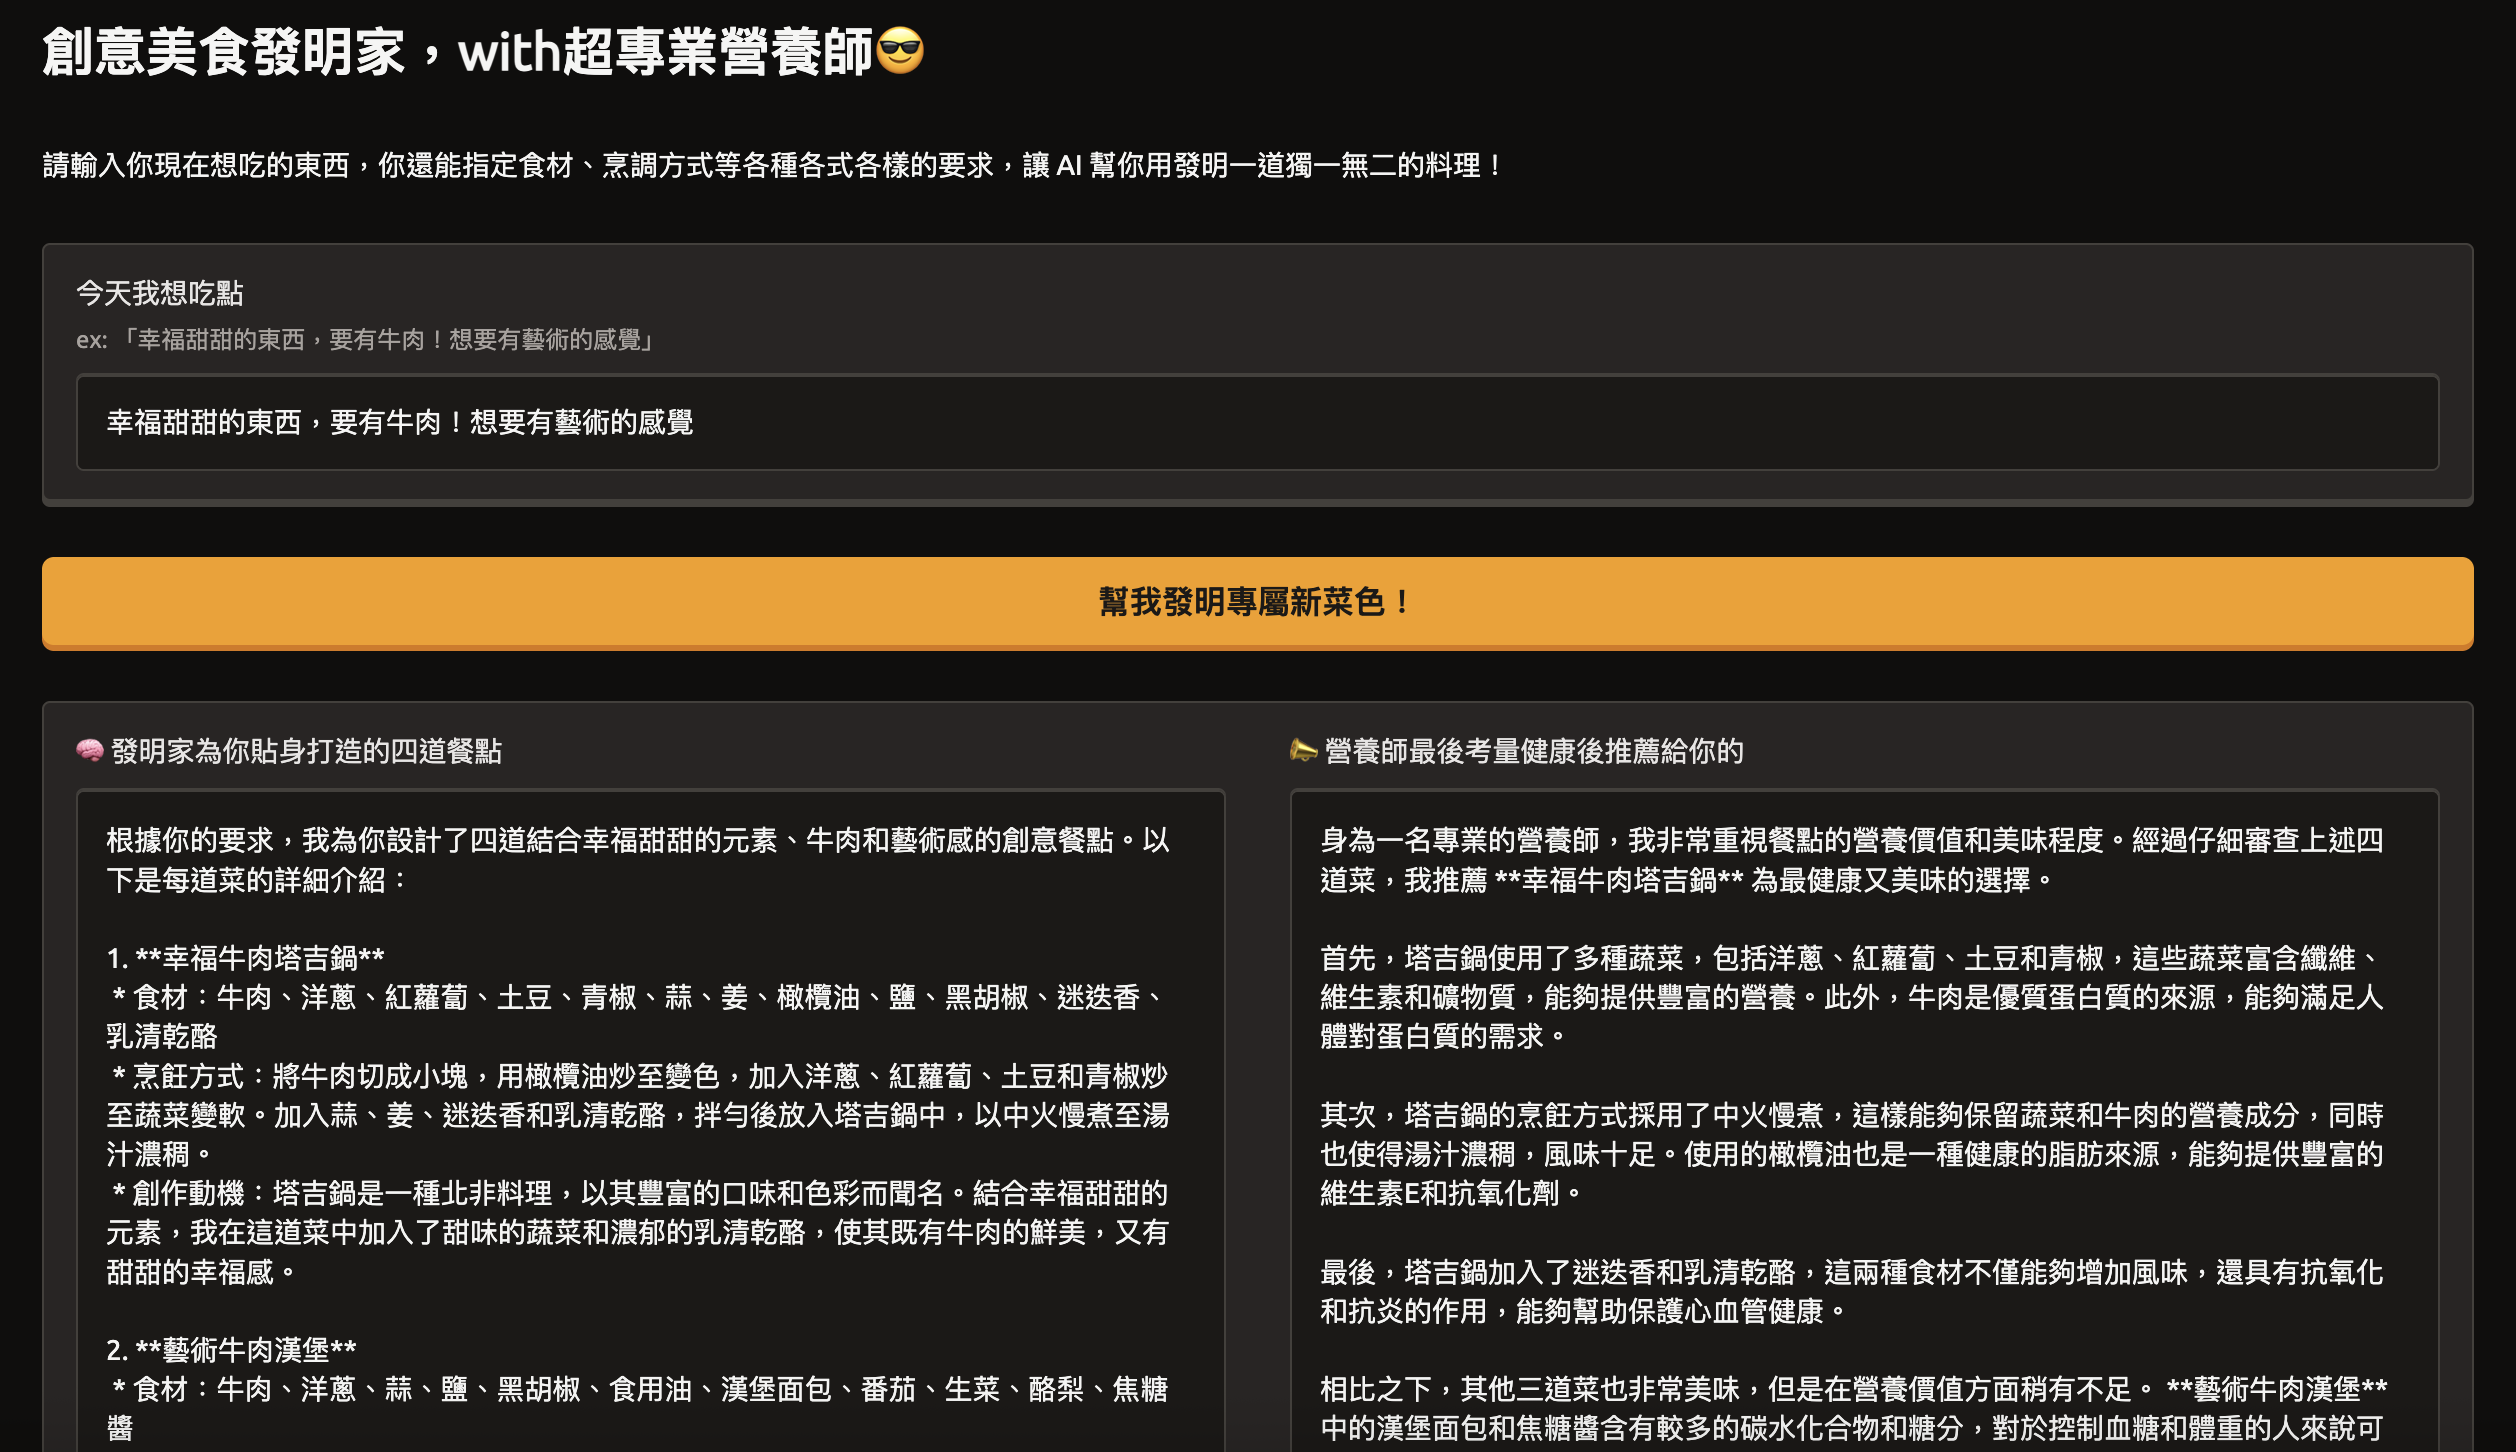